* [Bayesian *VAR*](https://www.pymc.io/projects/examples/en/latest/time_series/bayesian_var_model.html)
* [For Prediction Mechanics](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html): [Prediction Step](https://www.pymc.io/projects/examples/en/latest/time_series/Forecasting_with_structural_timeseries.html#prediction-step)
* [PyMC Labs Bayesian *VAR*](https://www.pymc-labs.com/blog-posts/bayesian-vector-autoregression/)
* [Stationarity & Differencing](https://people.duke.edu/~rnau/411diff.htm)
* [ARVIZ](https://python.arviz.org/en/stable/api/index.html)

# Preliminaries

In [1]:
import os

In [2]:
os.chdir(path=os.getcwd())

In [3]:
os.getcwd()

'/content'

<br>

## Libraries

In [4]:
!pip install blackjax > blackjax.log

In [5]:
import time
import datetime
import json
import yaml
import urllib.request

import numpy as np
import pandas as pd

import arviz
import blackjax
import pymc
import pymc.math
import pymc.sampling.jax

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import statsmodels.graphics.tsaplots as sgt
import statsmodels.api as sa
import statsmodels.tsa.seasonal as stsl
import statsmodels.tsa.stattools as stst


In [6]:
import logging
import pytensor

<br>

## Settings

In [7]:
RANDOM_SEED = 5
rng = np.random.default_rng(RANDOM_SEED)

In [8]:
now = datetime.datetime.now()
offset = (now.weekday() - 1) % 7
tuesday = now - datetime.timedelta(days=offset)
stamp = tuesday.strftime('%Y-%m-%d')

<br>

## Graphing

In [9]:
matplotlib.rcParams.update({'font.size': 13})
matplotlib.rcParams['text.usetex'] = False

sns.set(font_scale=1)
sns.set_style('dark')

plt.rcParams['figure.constrained_layout.use'] = False

In [10]:
%config InlineBackend.figure_format = 'retina'

<br>

## Logging

```python
logging.basicConfig(level=logging.INFO,
                    format='%\n(message)s\n%(asctime)s.%(msecs)03d',
                    datefmt='%Y-%m-%d %H:%M:%S', force=True, encoding='utf-8')
logger = logging.getLogger(__name__)
```

<br>
<br>

# Classes

## Background

In [11]:
def shade_background(ppc, ax, idx, unsubscritable=False, palette="cividis"):
    palette = palette
    cmap = plt.get_cmap(palette)
    percs = np.linspace(51, 99, 100)
    colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
    for i, p in enumerate(percs[::-1]):
        upper = np.percentile(
            ppc[:, idx, :],
            p,
            axis=1,
        )
        lower = np.percentile(
            ppc[:, idx, :],
            100 - p,
            axis=1,
        )
        color_val = colors[i]
        if unsubscritable:
            ax.fill_between(
                x=np.arange(ppc.shape[0]),
                y1=upper.flatten(),
                y2=lower.flatten(),
                color=cmap(color_val),
                alpha=0.1,
            )
        else:
            ax[idx].fill_between(
                x=np.arange(ppc.shape[0]),
                y1=upper.flatten(),
                y2=lower.flatten(),
                color=cmap(color_val),
                alpha=0.1,
            )

<br>
<br>

## AR Step



> _"Define a helper function that will construct our autoregressive step for the marginal contribution of each lagged term in each of the respective time series equations"_



In [12]:
def calc_ar_step(lag_coefs, n_eqs, n_lags, df):
    ars = []
    for j in range(n_eqs):
        ar = pymc.math.sum(
            [
                pymc.math.sum(lag_coefs[j, i] * df.values[n_lags - (i + 1) : -(i + 1)], axis=-1)
                for i in range(n_lags)
            ],
            axis=0,
        )
        print(ar)
        ars.append(ar)
    beta = pymc.math.stack(ars, axis=-1)

    return beta


<br>
<br>

## Model



> _"Make the model in such a way that it can handle different specifications of the likelihood term and can be run for simple prior predictive checks. This latter functionality is important for debugging of shape handling issues.  Building a VAR model involves quite a few moving parts and it is handy to inspect the shape implied in the prior predictive checks."_



* [InferenceData.extend](https://python.arviz.org/en/latest/api/generated/arviz.InferenceData.extend.html#arviz.InferenceData.extend)

```python
def make_model(n_lags, n_eqs, df, priors, mv_norm=True, prior_checks=True):
    coords = {
        "lags": np.arange(n_lags) + 1,
        "equations": df.columns.tolist(),
        "cross_vars": df.columns.tolist(),
        "time": [x for x in df.index[n_lags:]],
    }

    with pymc.Model(coords=coords) as model:
        lag_coefs = pymc.Normal(
            "lag_coefs",
            mu=priors["lag_coefs"]["mu"],
            sigma=priors["lag_coefs"]["sigma"],
            dims=["equations", "lags", "cross_vars"],
        )
        alpha = pymc.Normal(
            "alpha", mu=priors["alpha"]["mu"], sigma=priors["alpha"]["sigma"], dims=("equations",)
        )
        data_obs = pymc.Data("data_obs", df.values[n_lags:], dims=["time", "equations"], mutable=True)

        betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df)
        betaX = pymc.Deterministic(
            "betaX",
            betaX
        )
        mean = alpha + betaX

        if mv_norm:
            n = df.shape[1]
            ## Under the hood the LKJ prior will retain the correlation matrix too.
            noise_chol, _, _ = pymc.LKJCholeskyCov(
                "noise_chol",
                eta=priors["noise_chol"]["eta"],
                n=n,
                sd_dist=pymc.HalfNormal.dist(sigma=priors["noise_chol"]["sigma"]),
            )
            obs = pymc.MvNormal(
                "obs", mu=mean, chol=noise_chol, observed=data_obs, dims=["time", "equations"]
            )
        else:
            ## This is an alternative likelihood that can recover sensible estimates of the coefficients
            ## But lacks the multivariate correlation between the timeseries.
            sigma = pymc.HalfNormal("noise", sigma=priors["noise"]["sigma"], dims=["equations"])
            obs = pymc.Normal(
                "obs", mu=mean, sigma=sigma, observed=data_obs, dims=["time", "equations"]
            )

        if prior_checks:
            idata = pymc.sample_prior_predictive()
            return model, idata
        else:
            idata = pymc.sample_prior_predictive()
            idata.extend(pymc.sample(draws=2000, random_seed=RANDOM_SEED))
            pymc.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=RANDOM_SEED)
    return model, idata
```

## Model

In [13]:
def make_hierarchical_model(n_lags, n_eqs, df, group_field, prior_checks=True):

    cols = [col for col in df.columns if col != group_field]
    coords = {"lags": np.arange(n_lags) + 1,
              "equations": cols
              }

    groups = df[group_field].unique()

    priors = {
        "noise": {"sigma": 3.0}
    }

    with pymc.Model(coords=coords) as model:

        # Hierarchical Priors
        alpha_hat_location = pymc.Normal("alpha_hat_location", 0.2, 0.25)
        alpha_hat_scale = pymc.InverseGamma("alpha_hat_scale", 3, 1.0)
        beta_hat_location = pymc.Normal("beta_hat_location", 0.2, 0.25)
        beta_hat_scale = pymc.InverseGamma("beta_hat_scale", 3, 1.0)

        for grp in groups:

            df_grp = df[df[group_field] == grp][cols]
            z_scale_beta = pymc.InverseGamma(f"z_scale_beta_{grp}", 2, 1.0)
            z_scale_alpha = pymc.InverseGamma(f"z_scale_alpha_{grp}", 2, 1.0)
            lag_coefs = pymc.Normal(
                f"lag_coefs_{grp}",
                mu=beta_hat_location,
                sigma=beta_hat_scale * z_scale_beta,
                dims=["equations", "lags"],
            )
            alpha = pymc.Normal(
                f"alpha_{grp}",
                mu=alpha_hat_location,
                sigma=alpha_hat_scale * z_scale_alpha,
                dims=("equations",)
            )

            betaX = calc_ar_step(lag_coefs, n_eqs, n_lags, df_grp)
            betaX = pymc.Deterministic(f"betaX_{grp}", betaX)
            mean = alpha + betaX

            sigma = pymc.HalfNormal(f'sigma_{grp}', sigma=priors["noise"]["sigma"], dims=["equations"])

            # This is an alternative likelihood that can recover sensible estimates of the coefficients,
            # but lacks the multivariate correlation between the timeseries.
            # pymc.Normal(f'likelihood_{grp}', mu=mean, sigma=sigma, observed=df_grp.values[n_lags:])

            # This is an alternative likelihood that can recover sensible estimates of the coefficients,
            # but lacks the multivariate correlation between the timeseries.
            degree = pymc.Uniform(f'degree_{grp}', lower=1, upper=5)
            pymc.StudentT(f'likelihood_{grp}', mu=mean, sigma=sigma, nu=degree, observed=df_grp.values[n_lags:])

        if prior_checks:
            idata = pymc.sample_prior_predictive(draws=2000, random_seed=100)
            return model, idata
        else:
            idata = pymc.sample_prior_predictive(draws=2000, random_seed=100)
            idata.extend(pymc.sampling.jax.sample_blackjax_nuts(2000, chains=4, random_seed=100, target_accept=0.95))
            idata.extend(pymc.sample_posterior_predictive(idata))

    return model, idata

<br>
<br>

# Data

## Classes

In [14]:
"""Module api.py"""

class API:
    """
    Notes<br>
    ------<br>

    For reading data sets from Scottish Health & Social Care <a href="https://www.opendata.nhs.scot" target="_blank">
    Open Data Platform</a>
    """

    def __init__(self):
        pass

    @staticmethod
    def __get_dictionary(url: str):
        """

        :param url: An application programming interface endpoint
        :return:
        """

        with urllib.request.urlopen(url=url) as blob:
            objects = blob.read()
        dictionary = json.loads(s=objects)

        return dictionary

    @staticmethod
    def __data(dictionary: dict) -> pd.DataFrame:
        """

        :param dictionary: An API (application programming interface) query output.
        :return:
        """

        try:
            frame = pd.DataFrame.from_dict(data=dictionary['result']['records'], orient='columns')
        except ImportError as err:
            raise err from err

        return frame

    def __call__(self, url: str) -> pd.DataFrame:
        """

        :param url: An application programming interface endpoint
        :return:
        """

        dictionary = self.__get_dictionary(url=url)
        data = self.__data(dictionary=dictionary)

        return data

## Read

In [15]:
space = '%20'
url = ("https://www.opendata.nhs.scot/api/3/action/datastore_search?"
       f"resource_id=a5f7ca94-c810-41b5-a7c9-25c18d43e5a4&limit=1000000&q='Type{space}1,Unplanned'")

In [16]:
api = API()

In [17]:
frame = api(url=url)

<br>

## Inspect

In [18]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15659 entries, 0 to 15658
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   _id                            15659 non-null  int64  
 1   WeekEndingDate                 15659 non-null  int64  
 2   Country                        15659 non-null  object 
 3   HBT                            15659 non-null  object 
 4   TreatmentLocation              15659 non-null  object 
 5   DepartmentType                 15659 non-null  object 
 6   AttendanceCategory             15659 non-null  object 
 7   NumberOfAttendancesEpisode     15659 non-null  int64  
 8   NumberWithin4HoursEpisode      15659 non-null  int64  
 9   NumberOver4HoursEpisode        15659 non-null  int64  
 10  PercentageWithin4HoursEpisode  15659 non-null  float64
 11  NumberOver8HoursEpisode        15659 non-null  int64  
 12  PercentageOver8HoursEpisode    15659 non-null 

<br>

**Uniqueness**

In [19]:
frame['DepartmentType'].unique()

array(['Type 1'], dtype=object)

In [20]:
frame['Country'].unique()

array(['S92000003'], dtype=object)

In [21]:
frame['AttendanceCategory'].unique()

array(['Unplanned'], dtype=object)

<br>

**Focus**

In [22]:
rename = {'WeekEndingDate': 'week_ending_date', 'HBT': 'health_board_code',
          'TreatmentLocation': 'treatment_location', 'NumberOfAttendancesEpisode': 'n_attendances'}

In [23]:
frame = frame.copy()[rename.keys()]

<br>

**Rename**

In [24]:
frame.rename(columns=rename, inplace=True)
frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15659 entries, 0 to 15658
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   week_ending_date    15659 non-null  int64 
 1   health_board_code   15659 non-null  object
 2   treatment_location  15659 non-null  object
 3   n_attendances       15659 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 489.5+ KB


<br>

**Ascertain Date Format**

In [25]:
frame['week_ending_date'] = pd.to_datetime(frame['week_ending_date'].astype(dtype=str), errors='coerce', format='%Y%m%d')
frame.head()

,week_ending_date,health_board_code,treatment_location,n_attendances
0,2022-08-14,S08000017,Y146H,710
1,2015-02-22,S08000015,A111H,1347
2,2022-09-04,S08000030,T101H,1133
3,2022-09-04,S08000028,W107H,121
4,2022-09-11,S08000015,A210H,650


<br>

**Profile**

In [26]:
frame['n_attendances'].describe()

,n_attendances
count,15659.000000
mean,836.273198
std,562.968221
min,37.000000
25%,302.000000
50%,776.000000
75%,1226.000000
max,2688.000000


<br>
<br>

## Structure

In [27]:
frame.set_index(keys='week_ending_date', drop=True, inplace=True)
frame.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], ignore_index=False, inplace=True)

In [28]:
frame.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15659 entries, 2015-02-22 to 2025-02-09
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   health_board_code   15659 non-null  object
 1   treatment_location  15659 non-null  object
 2   n_attendances       15659 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 489.3+ KB


<br>
<br>

# Excerpt

In [29]:
assets = frame[['health_board_code', 'treatment_location']].drop_duplicates()
assets[['health_board_code']].groupby('health_board_code').value_counts()

,count
health_board_code,
S08000015,2
S08000016,1
S08000017,2
S08000019,1
S08000020,3
S08000022,4
S08000024,3
S08000025,1
S08000026,1


<br>
<br>

## Data

In [30]:
excerpt = frame.copy().loc[frame['health_board_code'] == 'S08000017', :]
excerpt.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], inplace=True)

In [31]:
excerpt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042 entries, 2015-02-22 to 2025-02-09
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   health_board_code   1042 non-null   object
 1   treatment_location  1042 non-null   object
 2   n_attendances       1042 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 32.6+ KB


<br>
<br>

## Counts

In [32]:
doublet = excerpt[['health_board_code', 'treatment_location']].drop_duplicates()
for i in range(doublet.shape[0]):
    print(doublet.health_board_code.iloc[i], doublet.treatment_location.iloc[i])

S08000017 Y144H
S08000017 Y146H


In [33]:
counts = excerpt[['health_board_code', 'treatment_location']].groupby(by='health_board_code').value_counts().to_frame()
counts.reset_index(inplace=True)
counts.head()

,health_board_code,treatment_location,count
0,S08000017,Y144H,521
1,S08000017,Y146H,521


In [34]:
counts.loc[counts['count'] >= (3 * 52), :]

,health_board_code,treatment_location,count
0,S08000017,Y144H,521
1,S08000017,Y146H,521


<br>
<br>

## Curves

In [35]:
locating = mdates.YearLocator(2)
formatting = mdates.DateFormatter('%Y')

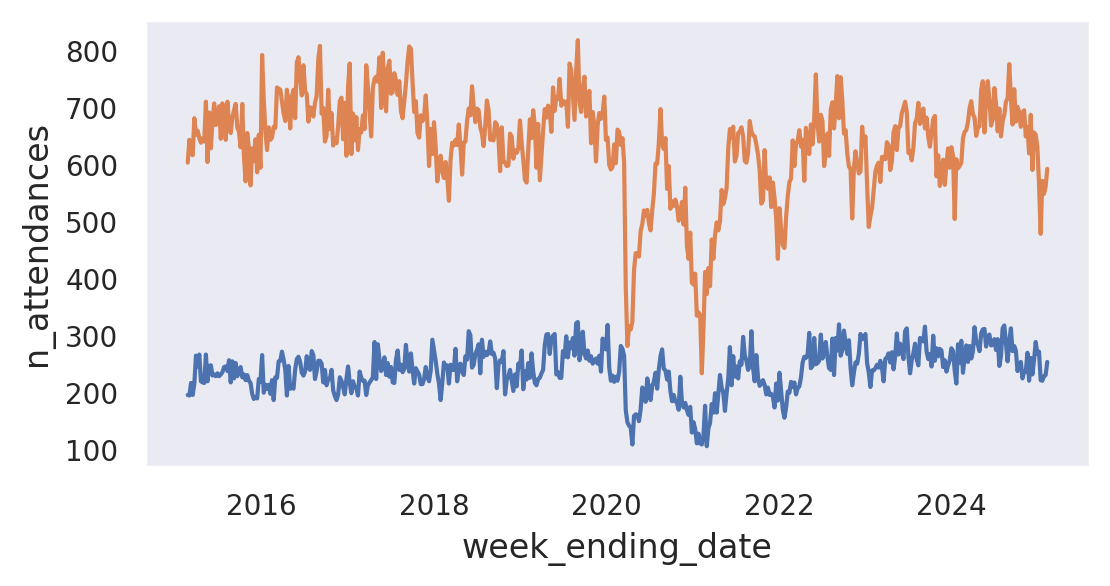

In [36]:
fig = plt.figure(figsize=(6.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=excerpt, x=excerpt.index, y='n_attendances', hue='treatment_location', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

<br>
<br>

## Test

In [37]:
valuation = excerpt.copy().loc[excerpt['treatment_location'] == 'Y144H', :]
valuation.sort_values(by=['week_ending_date'], ascending=True, inplace=True)

In [38]:
valuation['ln'] = np.log(valuation['n_attendances'])
valuation['sa'] = valuation['ln'].diff(periods=52)
valuation['dt'] = valuation['sa'].diff(periods=1)
valuation['ft'] = valuation['dt'].diff(periods=1)

In [39]:
valuation.head()

,health_board_code,treatment_location,n_attendances,ln,sa,dt,ft
week_ending_date,,,,,,,
2015-02-22,S08000017,Y144H,196,5.278115,NaN,NaN,NaN
2015-03-01,S08000017,Y144H,195,5.273000,NaN,NaN,NaN
2015-03-08,S08000017,Y144H,217,5.379897,NaN,NaN,NaN
2015-03-15,S08000017,Y144H,196,5.278115,NaN,NaN,NaN
2015-03-22,S08000017,Y144H,216,5.375278,NaN,NaN,NaN


<br>
<br>

# Decompositions

In [40]:
places = excerpt['treatment_location'].unique()
places.view()

array(['Y144H', 'Y146H'], dtype=object)

<br>
<br>

## Graphs

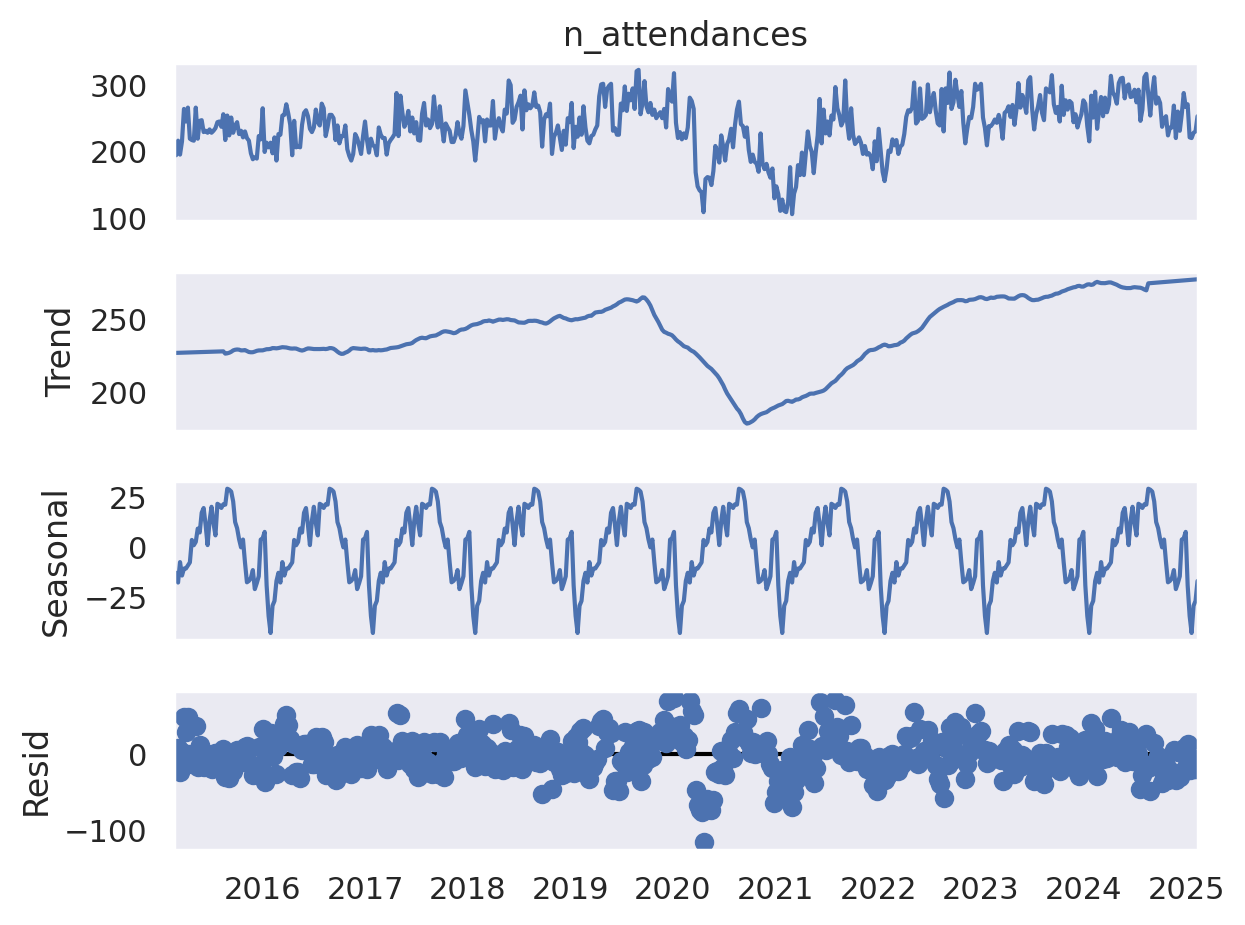

In [41]:
conditionals = excerpt['treatment_location'] == places[0]
graphs = stsl.seasonal_decompose(x=excerpt.loc[conditionals, 'n_attendances'], model='additive', period=52, extrapolate_trend='freq')
graphs.plot()
plt.show()

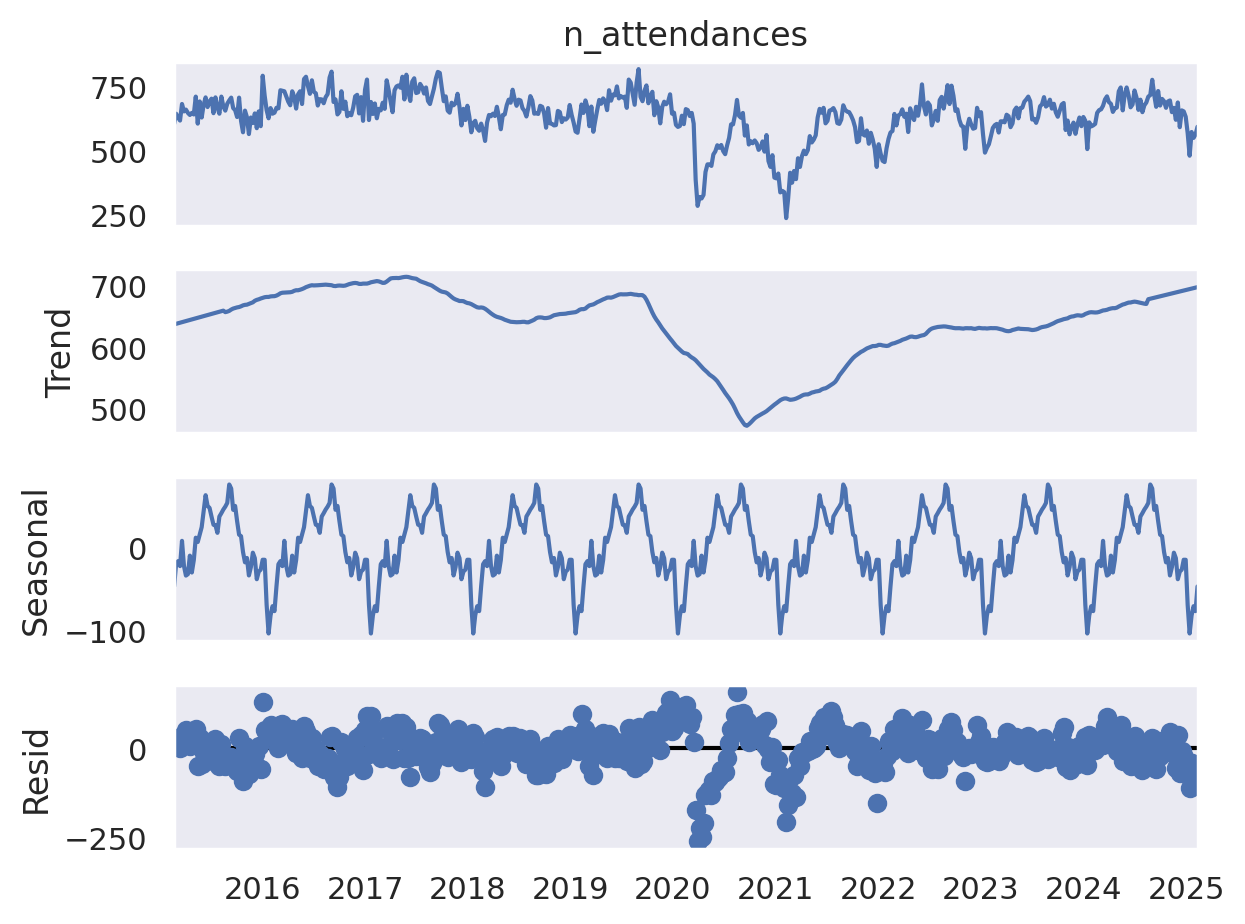

In [42]:
conditionals = excerpt['treatment_location'] == places[1]
graphs = stsl.seasonal_decompose(x=excerpt.loc[conditionals, 'n_attendances'], model='additive', period=52, extrapolate_trend='freq')
graphs.plot()
plt.show()

<br>
<br>

## Series

Times

* **milliseconds** $\rightarrow$ **date**: `pd.to_datetime(decompositions['milliseconds'], unit='ms')`

In [43]:
class Parts:

    def __init__(self, blob: pd.DataFrame, period: int) -> None:

        self.__blob = blob
        self.__period = period

    def __disaggregate(self, tl: str) -> stsl.DecomposeResult:

        conditionals = self.__blob['treatment_location'] == tl

        graphs = stsl.seasonal_decompose(
            x=self.__blob.loc[conditionals, 'n_attendances'], model='additive', period=self.__period, extrapolate_trend='freq')

        return graphs

    def __decompositions(self, graphs: stsl.DecomposeResult):

        decompositions = pd.DataFrame(
            data={'observation': graphs.observed.values, 'trend': graphs.trend.values, 'seasonal': graphs.seasonal.values,
                'residue': graphs.resid.values}, index=graphs.observed.index)

        decompositions.reset_index(inplace=True)
        decompositions.sort_values(by='week_ending_date', inplace=True)

        return decompositions

    def __milliseconds(self, decompositions: pd.DataFrame):
        """
        (decompositions['week_ending_date'].to_numpy().astype(np.int64) / (10 ** 6)).astype(np.longlong)

        :param decompositions:
        """

        nanoseconds: pd.Series = pd.to_datetime(decompositions['week_ending_date'], format='%Y-%m-%d').astype(np.int64)
        milliseconds: pd.Series = (nanoseconds / (10 ** 6)).astype(np.longlong)
        decompositions['milliseconds'] = milliseconds.values

        return decompositions

    def __identifiers(self, decompositions: pd.DataFrame, tl: str):

        hbc = self.__blob.loc[self.__blob['treatment_location'] == tl, 'health_board_code'].unique()[0]

        decompositions['treatment_location'] = tl
        decompositions['health_board_code'] = hbc

        return decompositions

    def exc(self):

        computations = []
        for tl in self.__blob['treatment_location'].unique():

            graphs = self.__disaggregate(tl=tl)
            decompositions = self.__decompositions(graphs=graphs)
            decompositions = self.__milliseconds(decompositions=decompositions.copy())
            decompositions = self.__identifiers(decompositions=decompositions.copy(), tl=tl)

            computations.append(decompositions)

        calculations = pd.concat(computations, axis=0, ignore_index=True)
        calculations.set_index(keys='week_ending_date', drop=True, inplace=True)

        del computations

        return calculations


In [44]:
parts = Parts(blob=excerpt, period=52).exc()

In [45]:
parts.head()

,observation,trend,seasonal,residue,milliseconds,treatment_location,health_board_code
week_ending_date,,,,,,,
2015-02-22,196.0,227.115204,-16.972841,-14.142363,1424563200000,Y144H,S08000017
2015-03-01,195.0,227.159253,-12.876525,-19.282728,1425168000000,Y144H,S08000017
2015-03-08,217.0,227.203301,-17.739584,7.536283,1425772800000,Y144H,S08000017
2015-03-15,196.0,227.247349,-7.509373,-23.737976,1426377600000,Y144H,S08000017
2015-03-22,216.0,227.291398,-14.231086,2.939688,1426982400000,Y144H,S08000017


<br>
<br>

## Test

In [46]:
example = parts.loc[parts['treatment_location'] == 'Y144H', 'trend'].to_frame()
example['ln'] = np.log(example['trend'].values)
example.sort_values(by='week_ending_date', ascending=True, inplace=True)
example['d_of_ln'] = example['ln'].diff(periods=1)
example['d_d_of_ln'] = example['d_of_ln'].diff(periods=1)
example.head()

,trend,ln,d_of_ln,d_d_of_ln
week_ending_date,,,,
2015-02-22,227.115204,5.425457,NaN,NaN
2015-03-01,227.159253,5.425651,0.000194,NaN
2015-03-08,227.203301,5.425845,0.000194,-3.760080e-08
2015-03-15,227.247349,5.426039,0.000194,-3.758622e-08
2015-03-22,227.291398,5.426233,0.000194,-3.757165e-08


(0.0, 85.0)

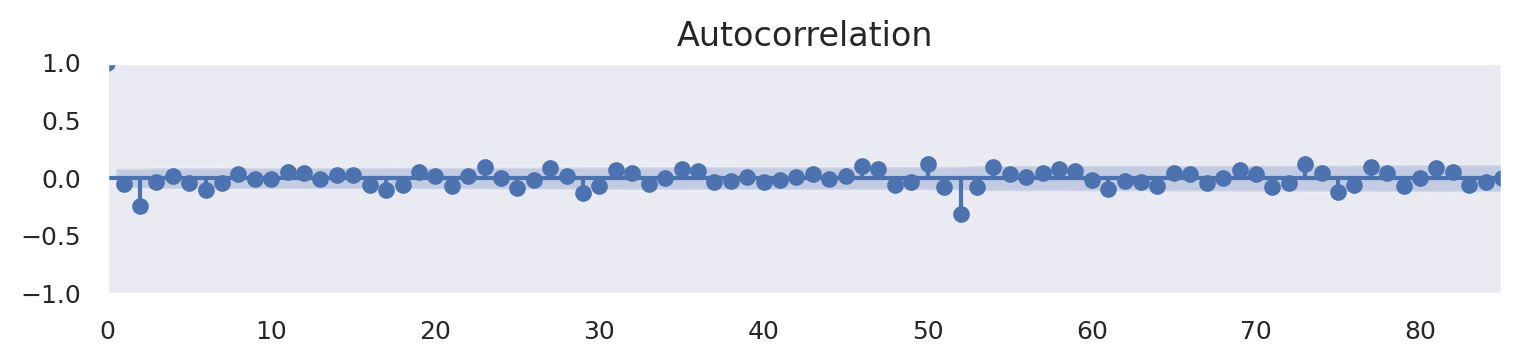

In [47]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 1.5))

sgt.plot_acf(
    example['d_d_of_ln'][2:], ax=ax, lags=85, alpha=0.05, use_vlines=True, adjusted=False, fft=False,
    missing='none', title='Autocorrelation', zero=True, auto_ylims=False, bartlett_confint=True, vlines_kwargs=None)

ax.set_xlim(left=0, right=85)

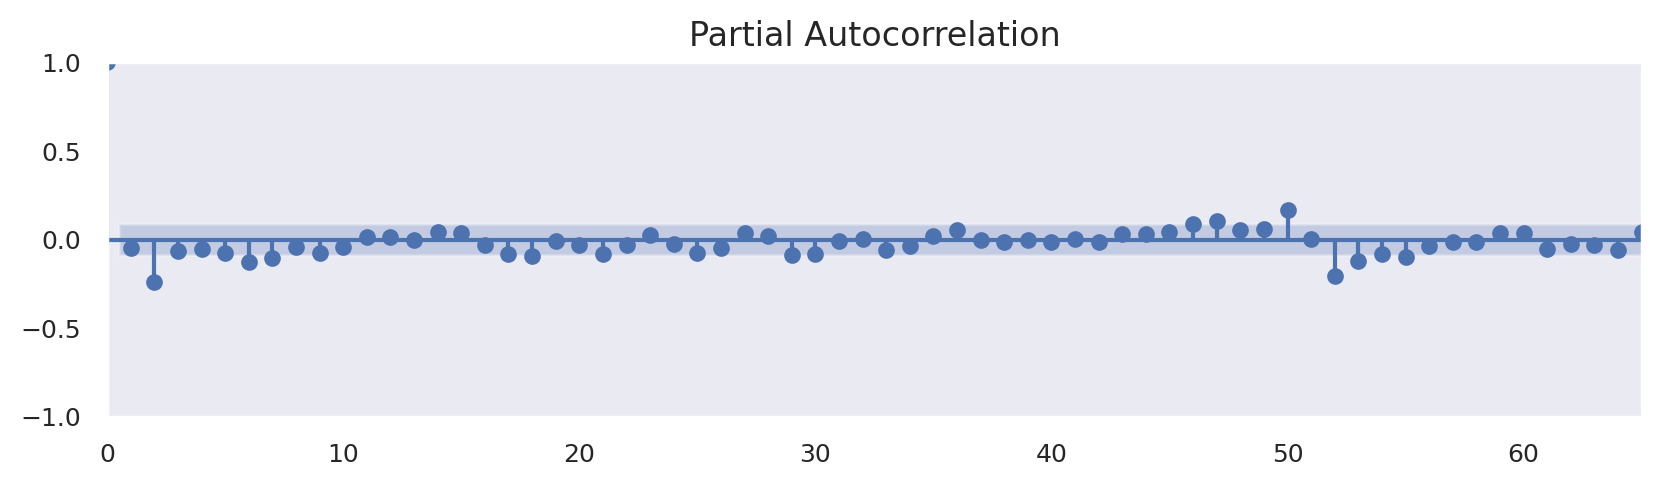

In [48]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.9, 2.3))

sa.graphics.tsa.plot_pacf(x=example['d_d_of_ln'][2:], ax=ax, lags=85, alpha=0.05)

ax.set_xlim(left=0, right=65)

plt.show()

<br>
<br>

## Features

In [49]:
ahead = 9

<br>

**Starting**

In [50]:
reduce = False

if reduce:
    reduced = excerpt.copy().loc[excerpt.index >= datetime.datetime.strptime('2020-10-01', '%Y-%m-%d'), :]
else:
    reduced = excerpt

In [51]:
reduced.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042 entries, 2015-02-22 to 2025-02-09
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   health_board_code   1042 non-null   object
 1   treatment_location  1042 non-null   object
 2   n_attendances       1042 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 32.6+ KB


<br>

**Class**

In [52]:
class Features:

    def __init__(self, future: int) -> None:

        self.__future = future
        self.__season = 52
        self.__trend = 1

    def __ln(self, blob: pd.DataFrame):

        blob['ln'] = np.log(blob['n_attendances'].to_numpy())
        blob['sa'] = blob['ln'].diff(periods=self.__season)
        blob['dt'] = blob['sa'].diff(periods=self.__trend)

        return blob

    def exc(self, dataset: pd.DataFrame):

        instances = self.__ln(blob=dataset.copy())

        # For post-modelling analysis
        pre = instances.copy()[:-self.__future]

        # Exclude NaN instances vis-a-vis `dt`
        calc = instances.copy().loc[instances['dt'].notna(), :]

        # Exclude instances that will be predicted
        inc = calc.copy()[:-self.__future]
        exc = calc.copy()[-self.__future:]

        return inc, exc, instances, pre


In [53]:
features = Features(future=ahead)

<br>

**Compute**

In [54]:
_inc = []
_exc = []
_instances = []
_pre = []
for code in reduced['treatment_location'].unique():
    dataset = reduced.copy().loc[reduced['treatment_location'] == code, :]
    inc, exc, instances, pre = features.exc(dataset=dataset)
    _inc.append(inc)
    _exc.append(exc)
    _instances.append(instances)
    _pre.append(pre)
data = pd.concat(_inc, axis=0, ignore_index=False)
testing = pd.concat(_exc, axis=0, ignore_index=False)
database = pd.concat(_instances, axis=0, ignore_index=False)
investigate = pd.concat(_pre, axis=0, ignore_index=False)


In [55]:
data.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], inplace=True)
testing.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], inplace=True)
database.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], inplace=True)
investigate.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], inplace=True)

<br>

**Graphs**

In [56]:
locating = mdates.YearLocator(2)
formatting = mdates.DateFormatter('%Y')

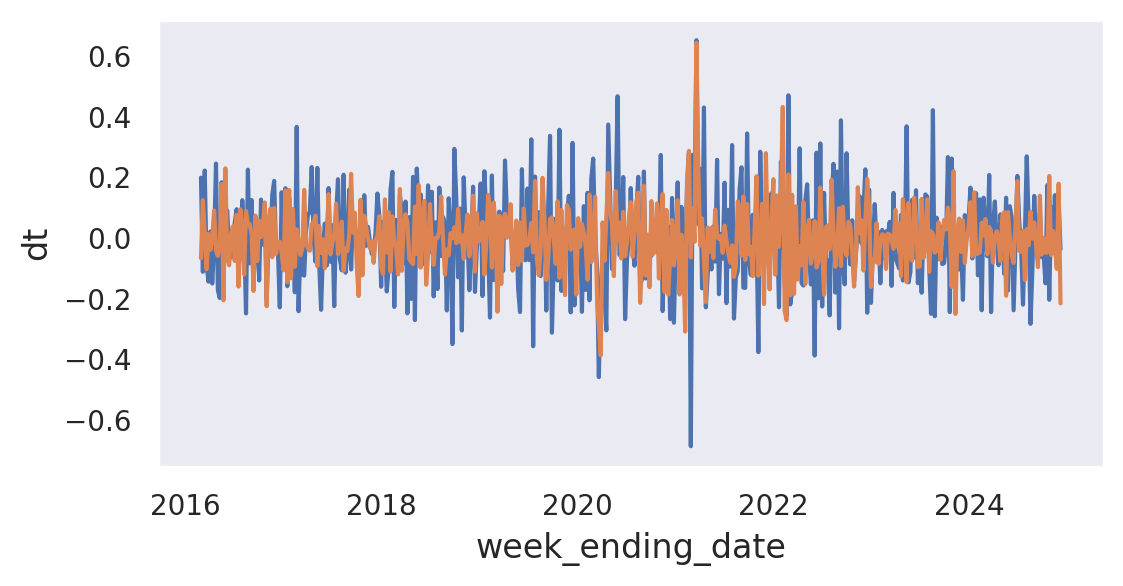

In [57]:
fig = plt.figure(figsize=(6.1, 2.9))
handle = fig.gca()
handle.tick_params(axis='both', labelsize='small')

sns.lineplot(data=data, x=data.index, y='dt', hue='treatment_location', ax=handle)

handle.xaxis.set_major_locator(locating)
handle.xaxis.set_major_formatter(formatting)

handle.get_legend().remove()

In [58]:
places = data['treatment_location'].unique()
places.view()

array(['Y144H', 'Y146H'], dtype=object)

In [59]:
conditionals = data['treatment_location'] == places[0]

(0.0, 65.0)

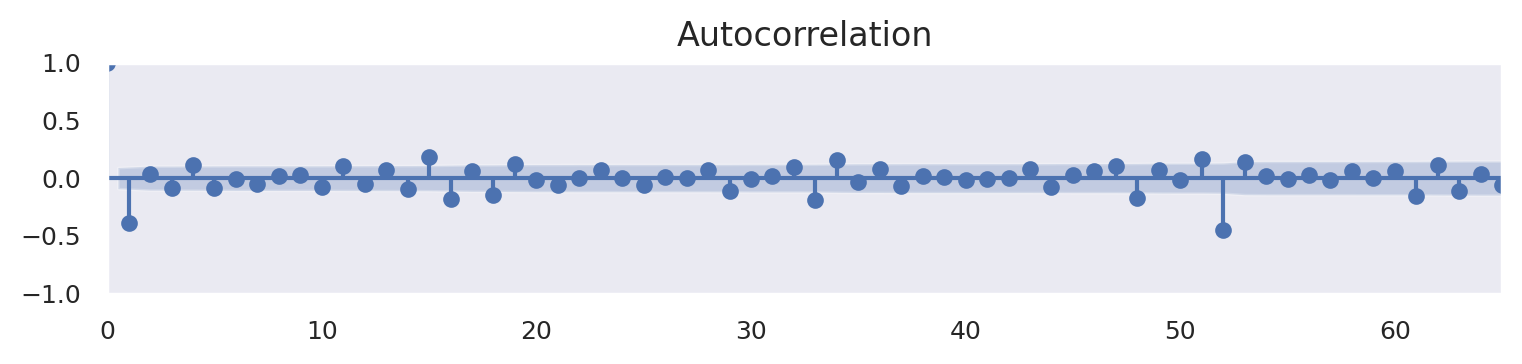

In [60]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 1.5))

sgt.plot_acf(
    data.loc[conditionals, 'dt'], ax=ax, lags=65, alpha=0.05, use_vlines=True, adjusted=False, fft=False,
    missing='none', title='Autocorrelation', zero=True, auto_ylims=False, bartlett_confint=True, vlines_kwargs=None)

ax.set_xlim(left=0, right=65)

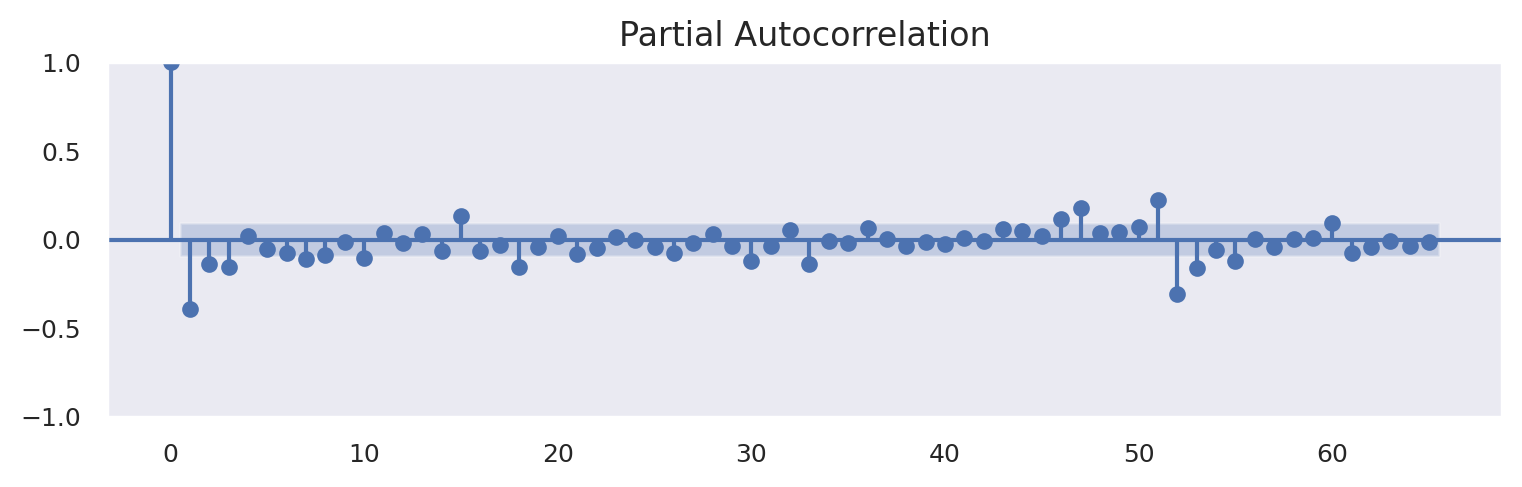

In [61]:
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)
fig, ax = plt.subplots(1, 1, figsize=(9.0, 2.3))

sa.graphics.tsa.plot_pacf(x=data.loc[conditionals, 'dt'], ax=ax, lags=65, alpha=0.05)
plt.show()

<br>
<br>

# All

## Modelling

In [62]:
n_lags = 53
n_eqs = 1

In [63]:
model_full_test, idata_full_test = make_hierarchical_model(
    n_lags=n_lags,
    n_eqs=n_eqs,
    df=data[['treatment_location', 'dt']],
    group_field='treatment_location',
    prior_checks=False
)

Sum{axis=0}.0
Sum{axis=0}.0
Running window adaptation


Output()

##Aft: Architecture

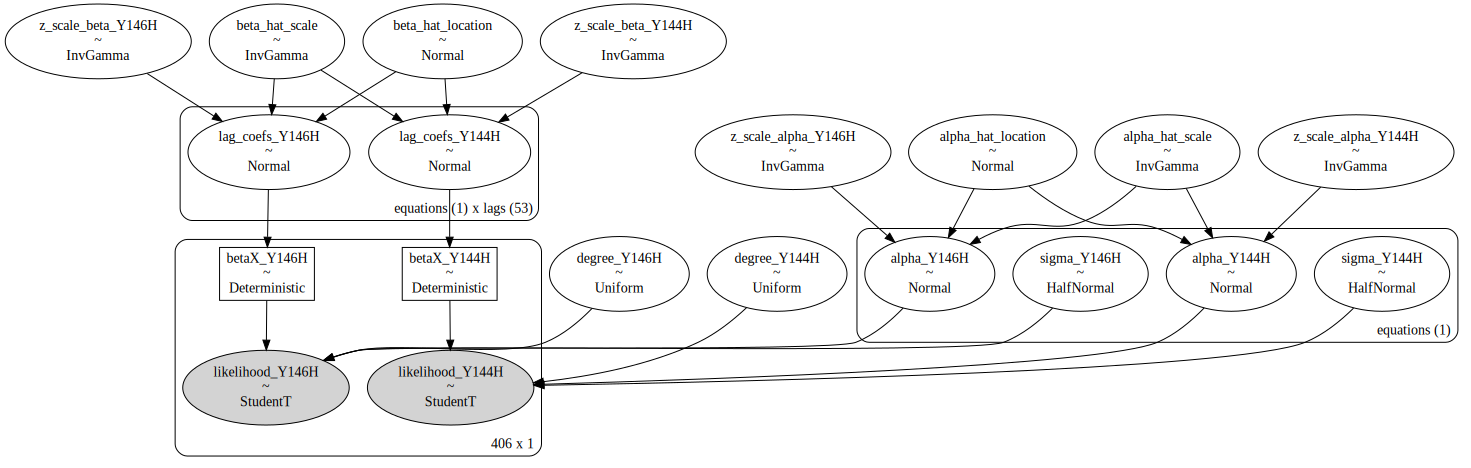

In [64]:
pymc.model_to_graphviz(model_full_test, save='graph.pdf', figsize=(5,5))

<br>
<br>

## Aft: Estimates

In [65]:
model_full_test.named_vars

{'alpha_hat_location': alpha_hat_location,
 'alpha_hat_scale': alpha_hat_scale,
 'beta_hat_location': beta_hat_location,
 'beta_hat_scale': beta_hat_scale,
 'z_scale_beta_Y144H': z_scale_beta_Y144H,
 'z_scale_alpha_Y144H': z_scale_alpha_Y144H,
 'lag_coefs_Y144H': lag_coefs_Y144H,
 'alpha_Y144H': alpha_Y144H,
 'betaX_Y144H': betaX_Y144H,
 'sigma_Y144H': sigma_Y144H,
 'degree_Y144H': degree_Y144H,
 'likelihood_Y144H': likelihood_Y144H,
 'z_scale_beta_Y146H': z_scale_beta_Y146H,
 'z_scale_alpha_Y146H': z_scale_alpha_Y146H,
 'lag_coefs_Y146H': lag_coefs_Y146H,
 'alpha_Y146H': alpha_Y146H,
 'betaX_Y146H': betaX_Y146H,
 'sigma_Y146H': sigma_Y146H,
 'degree_Y146H': degree_Y146H,
 'likelihood_Y146H': likelihood_Y146H}

In [66]:
idata_full_test

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [67]:
arviz.summary(
    idata_full_test,
    var_names=["alpha_.*", "beta_.*", "sigma_*"], filter_vars='regex'
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_Y144H[dt],-0.001,0.006,-0.014,0.011,0.000,0.000,16577.0,5243.0,1.0
alpha_Y146H[dt],0.000,0.004,-0.007,0.008,0.000,0.000,18270.0,5385.0,1.0
alpha_hat_location,0.030,0.104,-0.161,0.246,0.002,0.001,5672.0,3748.0,1.0
alpha_hat_scale,0.320,0.216,0.086,0.660,0.003,0.002,8169.0,5795.0,1.0
beta_hat_location,-0.053,0.015,-0.080,-0.025,0.000,0.000,1356.0,2452.0,1.0
beta_hat_scale,0.237,0.077,0.110,0.376,0.001,0.001,4674.0,5646.0,1.0
sigma_Y144H[dt],0.109,0.005,0.099,0.119,0.000,0.000,9503.0,5995.0,1.0
sigma_Y146H[dt],0.067,0.004,0.060,0.074,0.000,0.000,7430.0,5913.0,1.0
z_scale_alpha_Y144H,0.597,0.562,0.105,1.387,0.009,0.006,9921.0,4532.0,1.0
z_scale_alpha_Y146H,0.584,0.510,0.107,1.332,0.007,0.005,8987.0,5125.0,1.0


<br>
<br>

## Aft: Trace

> axs[1,0].tick_params('x', rotation=90)

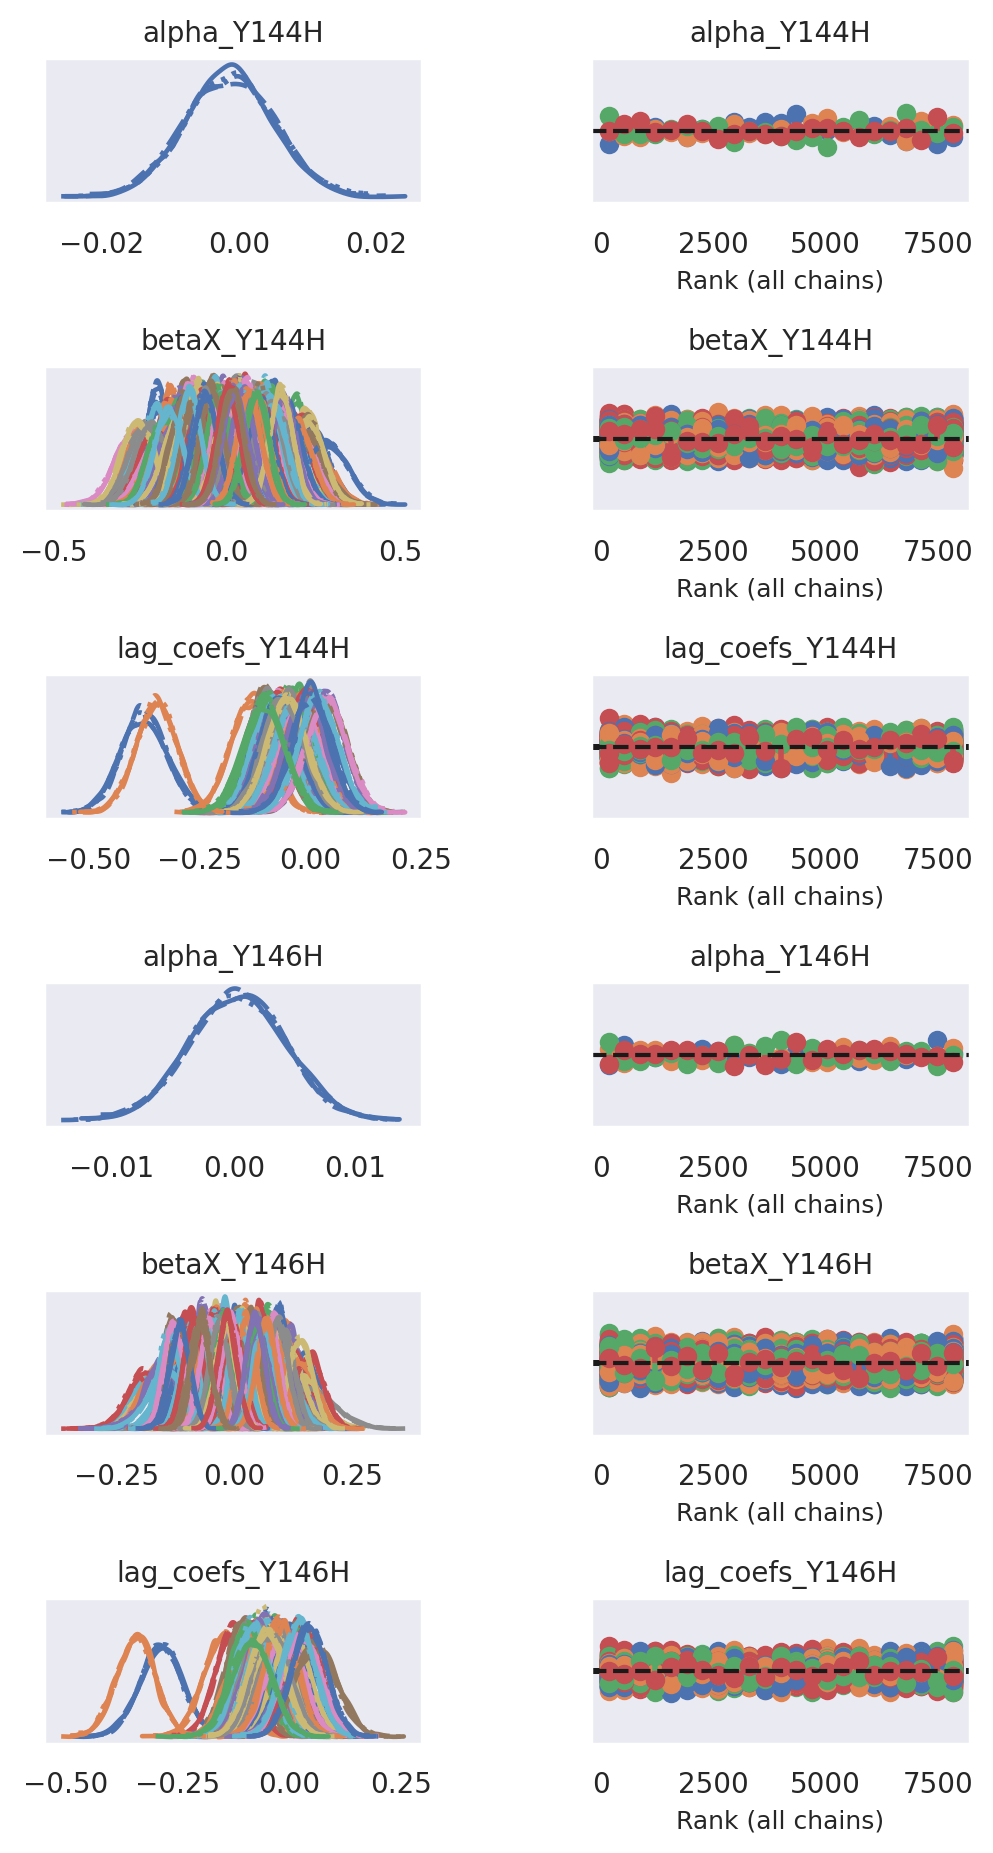

In [68]:
plt.rc('axes', titlesize=9, labelsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

fig, axs = plt.subplots(6, 2, figsize=(5.5, 9.1), width_ratios=(0.35, 0.35), height_ratios=np.repeat(0.1, repeats=6))
fig.tight_layout(w_pad=2.0, h_pad=3.0)

arviz.plot_trace(
    idata_full_test,
    var_names=[ "alpha_Y144H", "betaX_Y144H", "lag_coefs_Y144H", "alpha_Y146H", "betaX_Y146H", "lag_coefs_Y146H"],
    kind="rank_vlines", axes=axs
);


<br>
<br>

## Aft: Parameters

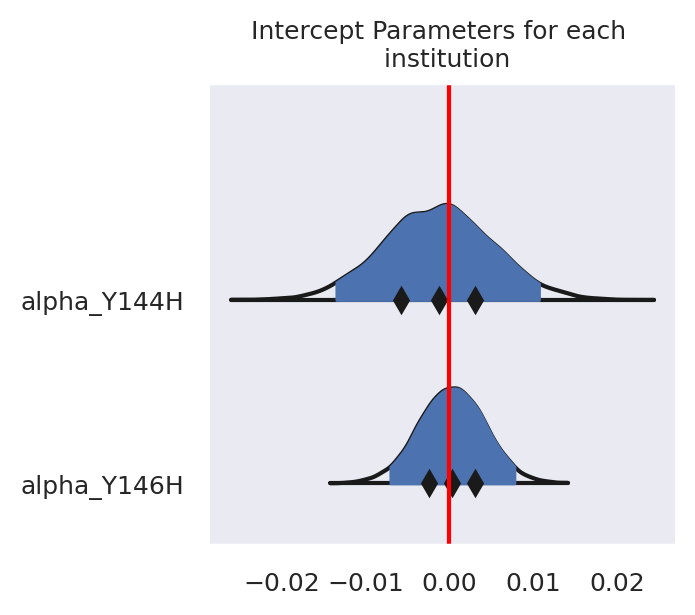

In [69]:
ax = arviz.plot_forest(
    idata_full_test,
    var_names=[
        "alpha_Y144H",
        "alpha_Y146H"
    ],
    kind="ridgeplot",
    combined=True,
    ridgeplot_truncate=False,
    ridgeplot_quantiles=[0.25, 0.5, 0.75],
    ridgeplot_overlap=0.7,
    figsize=(3, 3),
)

ax[0].axvline(0, color="red")
ax[0].set_title("Intercept Parameters for each \n institution");

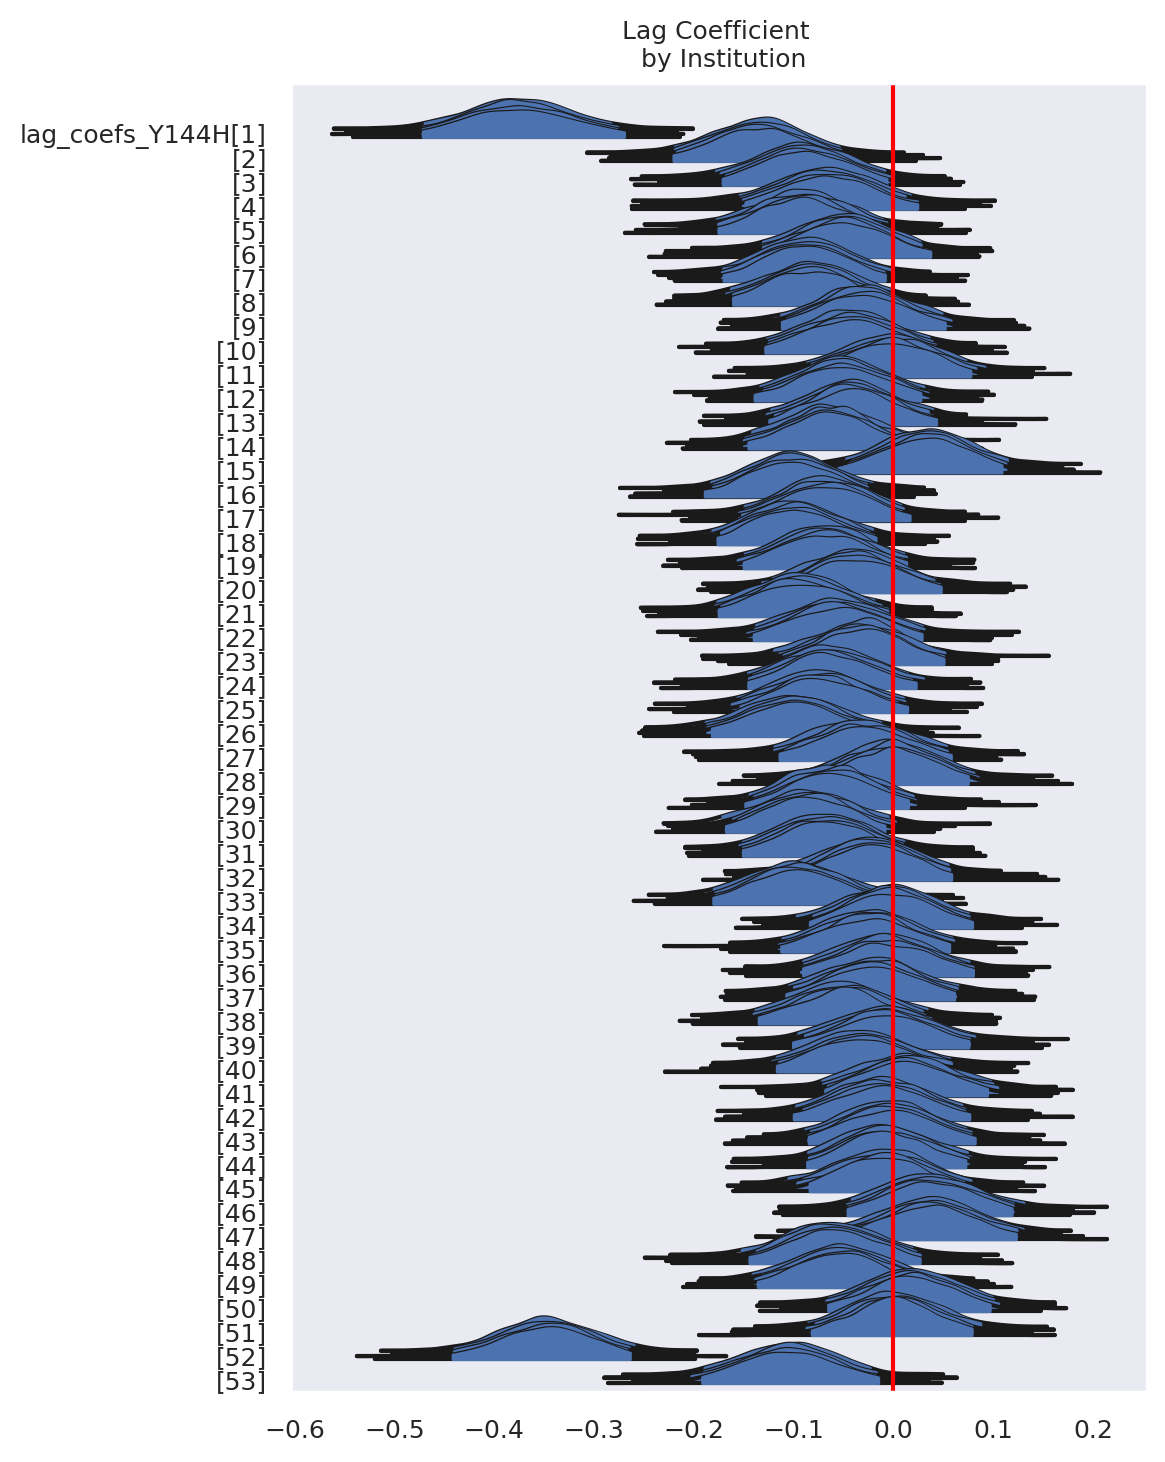

In [70]:
ax = arviz.plot_forest(
    idata_full_test,
    var_names=[
        "lag_coefs_Y144H"
    ],
    kind="ridgeplot",
    ridgeplot_truncate=False,
    figsize=(5.5, 8.5)
)
ax[0].axvline(0, color="red")
ax[0].set_title("Lag Coefficient \n by Institution");

<br>
<br>

## Aft: Model Fits

References:
* [Axes.legend](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.legend.html)
* [Legend Guide](https://matplotlib.org/stable/users/explain/axes/legend_guide.html)
* [matplotlib.pyplot.legend](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html#matplotlib.pyplot.legend)
* [Tick Label Rotation](https://matplotlib.org/stable/gallery/ticks/ticklabels_rotation.html)

**Parts**

In [71]:
model_full_test.named_vars

{'alpha_hat_location': alpha_hat_location,
 'alpha_hat_scale': alpha_hat_scale,
 'beta_hat_location': beta_hat_location,
 'beta_hat_scale': beta_hat_scale,
 'z_scale_beta_Y144H': z_scale_beta_Y144H,
 'z_scale_alpha_Y144H': z_scale_alpha_Y144H,
 'lag_coefs_Y144H': lag_coefs_Y144H,
 'alpha_Y144H': alpha_Y144H,
 'betaX_Y144H': betaX_Y144H,
 'sigma_Y144H': sigma_Y144H,
 'degree_Y144H': degree_Y144H,
 'likelihood_Y144H': likelihood_Y144H,
 'z_scale_beta_Y146H': z_scale_beta_Y146H,
 'z_scale_alpha_Y146H': z_scale_alpha_Y146H,
 'lag_coefs_Y146H': lag_coefs_Y146H,
 'alpha_Y146H': alpha_Y146H,
 'betaX_Y146H': betaX_Y146H,
 'sigma_Y146H': sigma_Y146H,
 'degree_Y146H': degree_Y146H,
 'likelihood_Y146H': likelihood_Y146H}

Useful:
> axs[i].legend(loc='lower right', fontsize=9)

In [72]:
class Drawing:

    def __init__(self, details):
        """
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot_mosaic.html

        :param sequence:
        :param predictions:
        """

        self.__details = details

    def exc(self):

        plt.rc('axes', titlesize=9, labelsize=9)
        plt.rc('xtick', labelsize=9)
        plt.rc('ytick', labelsize=9)

        fig, axs = plt.subplots(1, 2, figsize=(5.7, 2.3), width_ratios=(0.1, 0.1))
        fig.tight_layout(w_pad=2.0)

        arviz.plot_ppc(self.__details, ax=axs)

        axs[0].legend(loc='lower right', fontsize=9)
        axs[1].legend(loc='lower right', fontsize=9)

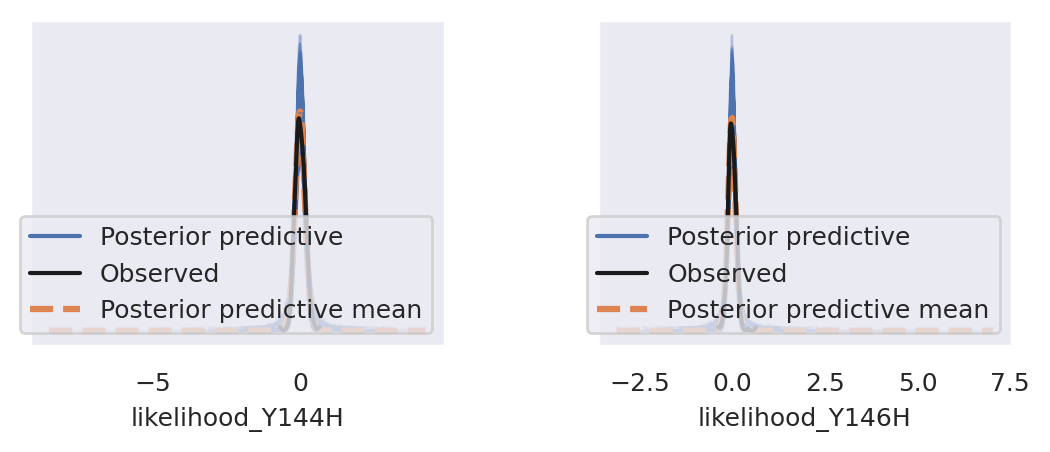

In [73]:
Drawing(details=idata_full_test).exc()

<br>
<br>

**Detailed**

In [74]:
places = data['treatment_location'].unique()
places.view()

array(['Y144H', 'Y146H'], dtype=object)

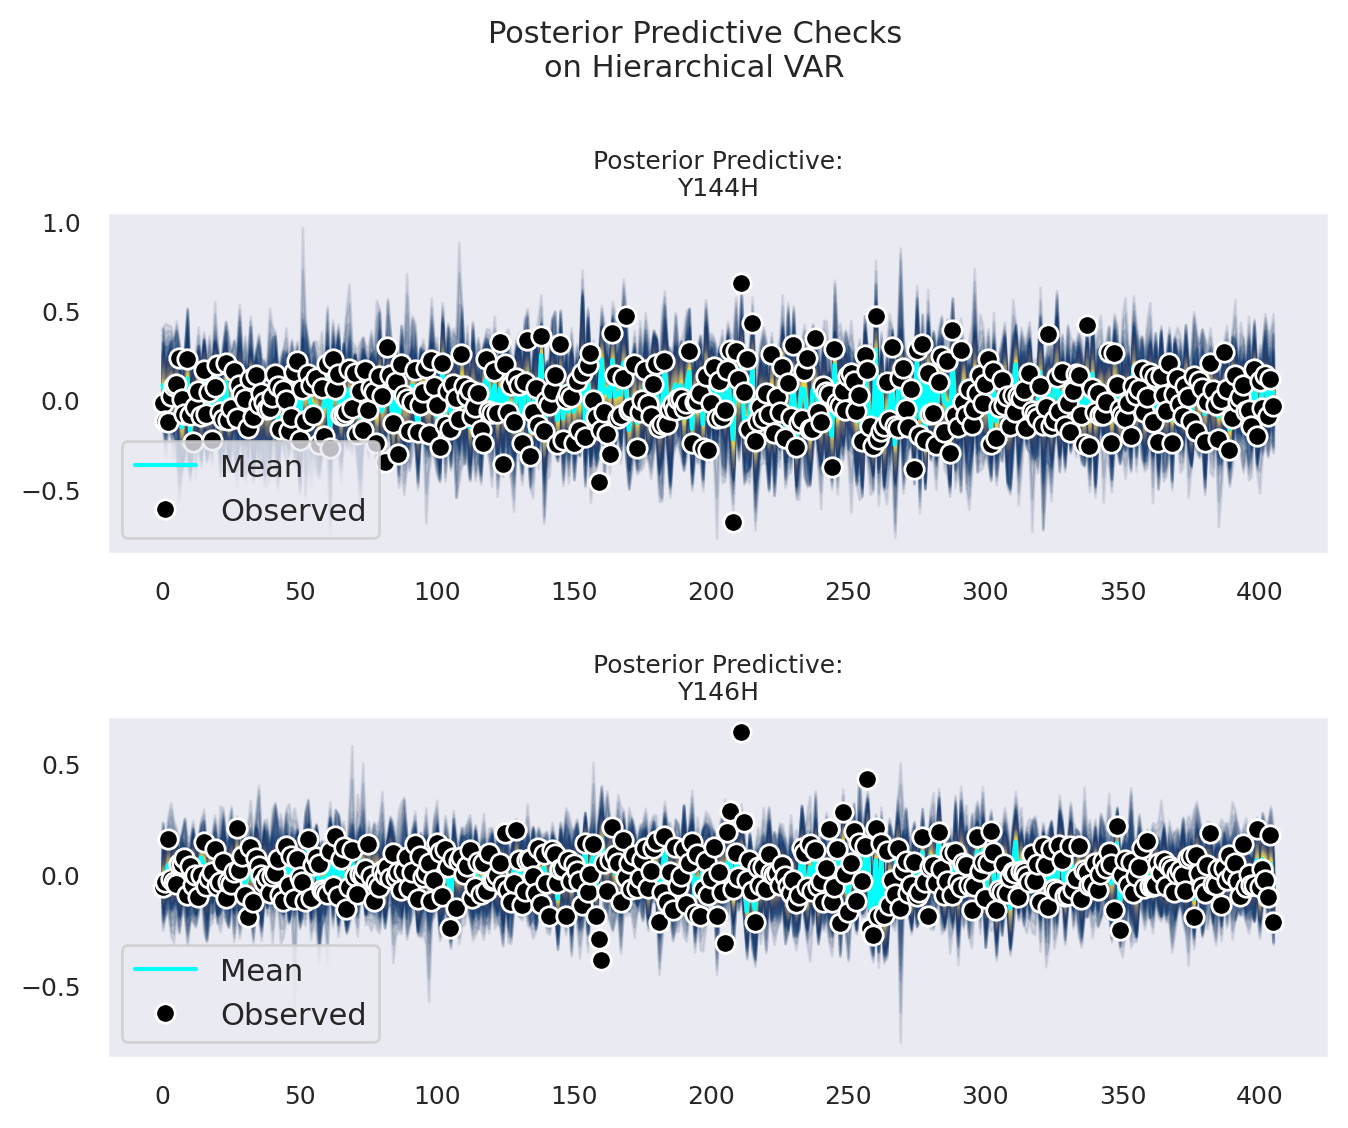

In [75]:
plt.rc('axes', titlesize=9, labelsize=9)
plt.rc('xtick', labelsize=9)
plt.rc('ytick', labelsize=9)

fig, axs = plt.subplots(places.shape[0], 1, figsize=(6.9, 4.9), height_ratios=np.repeat(0.1, places.shape[0]))
fig.tight_layout(w_pad=2.0, h_pad=3.0)

for ax, place in zip(axs, places):

    temp = pd.DataFrame(
        idata_full_test["observed_data"][f"likelihood_{place}"].data,
        columns=["dt"],
    )
    ppc = arviz.extract(idata_full_test, group="posterior_predictive", num_samples=100)[
        f"likelihood_{place}"
    ]
    colour = "inferno"
    for i in range(1):
        shade_background(ppc=ppc, ax=ax, idx=i, unsubscritable=True)
    ax.plot(np.arange(ppc.shape[0]), ppc[:, 0, :].mean(axis=1), color="cyan", label="Mean")
    ax.plot(temp["dt"], "o", mfc="black", mec="white", mew=1, markersize=7, label="Observed")
    ax.set_title(f"Posterior Predictive:\n{place}")
    ax.legend(loc="lower left")

plt.suptitle("Posterior Predictive Checks\non Hierarchical VAR", fontsize=11, y=1.15);


<br>
<br>

# Futures

In [76]:
idata_full_test

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [77]:
model_full_test

<br>
<br>

## Outline

* [Bayesian Vector Auto Regression](https://www.pymc-labs.com/blog-posts/bayesian-vector-autoregression/)
* [Data Container](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)
* [A Primer on Bayesian Methods for Multilevel Modeling](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html)

<br>

Chains & Draws

In [78]:
_chains = idata_full_test.sample_stats.sizes['chain']
_draws = idata_full_test.sample_stats.sizes['draw']

In [79]:
idata_full_test['sample_stats'].sizes['chain']

4

<br>
<br>

## Class

In [80]:
class Temporary:

    def __init__(self, _ahead, _lags, _lines):

        self.__ahead = _ahead
        self.__lags = _lags
        self.__lines = _lines

    # Function that takes a single draw of parameters and forecasts n steps
    def _forecast(self, intercept, lag_coefs, noise, forecast):

        len_lines = len(self.__lines)
        new_draws = np.zeros((self.__lines.shape[0]+forecast, self.__lines.shape[1]))

        # Fill the new array with the observed data
        new_draws[:len_lines] = self.__lines[:]
        for i in range(forecast):
            ar_ = np.sum(lag_coefs[:, 0] * new_draws[len_lines+i-self.__lags: len_lines+i])
            mean = intercept + ar_
            new_draws[len_lines+i] = rng.normal(mean, noise)

        # Replace all observed data with nan, so they don't show when we plot it
        new_draws[:-forecast-1] = np.nan

        return new_draws

    def exc(self, intercept_draws, lag_coefs_draws, noise_draws):

        # Vectorized forecast function to handle multiple parameter draws
        forecast = np.vectorize(
            self._forecast,
            signature=("(v),(l,v,v),(v)->(o,v)"),
            excluded=("self", "forecast"),
        )

        # Forecast ... weeks into the future
        ppc_draws = forecast(intercept_draws, lag_coefs_draws, noise_draws, forecast=self.__ahead)
        ppc_draws = np.swapaxes(ppc_draws, 0, 1)

        return ppc_draws


<br>
<br>

## Compute

<br>

A random subset of samples will be drawn from the posterior.  Ensure valid random indices by limiting the values range of the indices.

In [81]:
draws = rng.integers(_chains*_draws, size=500)

In [82]:
post = idata_full_test.posterior.stack(sample=('chain', 'draw'))

In [83]:
computations = []

for grp in data['treatment_location'].unique():

    lines = data.copy().loc[data['treatment_location'] == grp, ['dt']]

    intercept_draws = post[f'alpha_{grp}'].values.T[draws]

    lag_coefs_draws = post[f'lag_coefs_{grp}'].values.T[draws].T
    lag_coefs_draws = np.moveaxis(lag_coefs_draws, 2, 0)
    lag_coefs_draws = np.moveaxis(lag_coefs_draws, -1, 1)
    lag_coefs_draws = np.expand_dims(lag_coefs_draws, axis=3)

    noise_draws = post[f'sigma_{grp}'].values.T[draws]

    print(intercept_draws.shape, lag_coefs_draws.shape, noise_draws.shape)

    temporary = Temporary(_ahead=ahead, _lags=n_lags, _lines=lines)
    ppc_draws = temporary.exc(
        intercept_draws=intercept_draws, lag_coefs_draws=lag_coefs_draws, noise_draws=noise_draws)

    computations.append([ppc_draws, grp])


(500, 1) (500, 53, 1, 1) (500, 1)
(500, 1) (500, 53, 1, 1) (500, 1)


<br>
<br>

## Graphing

In [84]:
block = pd.concat((data, testing), axis=0, ignore_index=False)
block.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], ascending=True, inplace=True)

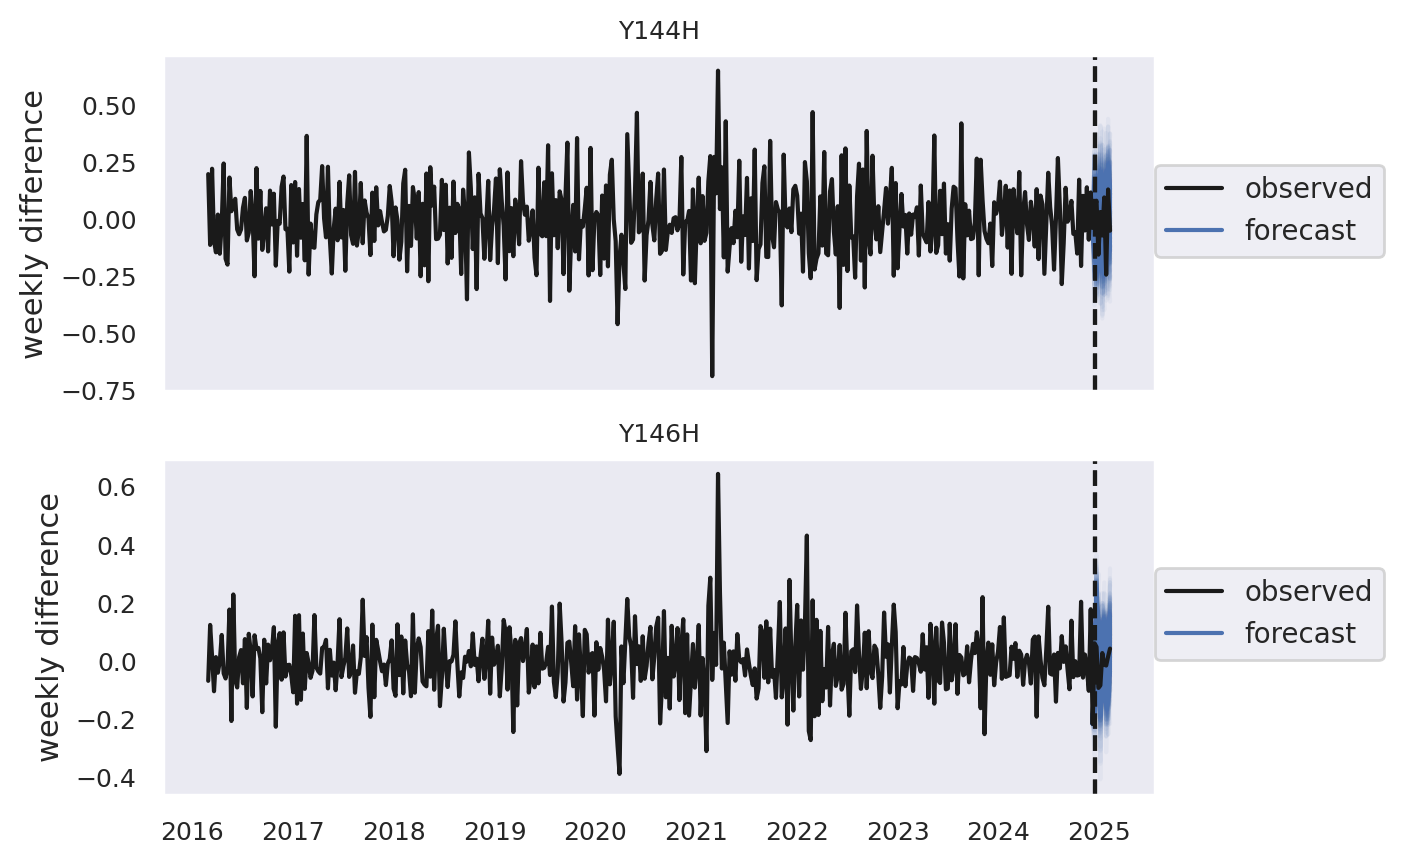

In [85]:
_, ax = plt.subplots(2, 1, sharex=True)

for i in range(len(computations)):

    df = block.copy().loc[block['treatment_location'] == computations[i][1], :]
    df.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], ascending=True, inplace=True)

    ax[i].set_title(computations[i][1])
    ax[i].plot(df.index, computations[i][0][..., 0], color='C0', alpha=0.05)
    ax[i].plot(df['dt'], color='k', label='observed')
    ax[i].plot([], color='C0', label='forecast')

    dt = testing.copy().loc[testing['treatment_location'] == computations[i][1], :]
    dt.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], ascending=True, inplace=True)

    for axi in ax:
        axi.axvline(dt.index[0], ls='--', color='k')
        axi.set_ylabel('weekly difference', fontsize=11)

    ax[i].legend(fontsize=10, loc=(1, .4))


<br>
<br>

# Inverting

In [86]:
database.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1042 entries, 2015-02-22 to 2025-02-09
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   health_board_code   1042 non-null   object 
 1   treatment_location  1042 non-null   object 
 2   n_attendances       1042 non-null   int64  
 3   ln                  1042 non-null   float64
 4   sa                  938 non-null    float64
 5   dt                  936 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 57.0+ KB


In [87]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 918 entries, 2016-02-28 to 2024-12-08
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   health_board_code   918 non-null    object 
 1   treatment_location  918 non-null    object 
 2   n_attendances       918 non-null    int64  
 3   ln                  918 non-null    float64
 4   sa                  918 non-null    float64
 5   dt                  918 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 50.2+ KB


In [88]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18 entries, 2024-12-15 to 2025-02-09
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   health_board_code   18 non-null     object 
 1   treatment_location  18 non-null     object 
 2   n_attendances       18 non-null     int64  
 3   ln                  18 non-null     float64
 4   sa                  18 non-null     float64
 5   dt                  18 non-null     float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1008.0+ bytes


In [89]:
investigate.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1024 entries, 2015-02-22 to 2024-12-08
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   health_board_code   1024 non-null   object 
 1   treatment_location  1024 non-null   object 
 2   n_attendances       1024 non-null   int64  
 3   ln                  1024 non-null   float64
 4   sa                  920 non-null    float64
 5   dt                  918 non-null    float64
dtypes: float64(3), int64(1), object(2)
memory usage: 56.0+ KB


<br>
<br>

## Estimates

> \# of points = $1 + 2(maximum - minimum)$

In [90]:
percentages = np.linspace(51, 99, 2*(99 - 51) + 1)

for i, j in enumerate(percentages[::-1]):

    upper = np.percentile(
        computations[0][0][-ahead:,:,0],
        j,
        axis=1,
    )
    lower = np.percentile(
        computations[0][0][-ahead:,:,0],
        100 - j,
        axis=1,
    )
    if j == 55:
        break


<br>
<br>

## Data Pieces

In [91]:
computations[0][1]

'Y144H'

In [92]:
computations[1][1]

'Y146H'

In [93]:
tailing = testing.copy().loc[testing['treatment_location'] == computations[0][1], :]
tailing.sort_values(by=['health_board_code', 'treatment_location', 'week_ending_date'], ascending=True, inplace=True)
tailing.tail()

,health_board_code,treatment_location,n_attendances,ln,sa,dt
week_ending_date,,,,,,
2025-01-12,S08000017,Y144H,222,5.402677,-0.073786,-0.070116
2025-01-19,S08000017,Y144H,221,5.398163,0.022884,0.096670
2025-01-26,S08000017,Y144H,229,5.433722,-0.218767,-0.241651
2025-02-02,S08000017,Y144H,231,5.442418,-0.087011,0.131756
2025-02-09,S08000017,Y144H,254,5.537334,-0.135989,-0.048978


<br>
<br>

## Class

In [94]:
class Inverting:

    def __init__(self, master: pd.DataFrame, indices: pd.DatetimeIndex):

        self.__master = master
        self.__indices = indices
        self.__retrend = 52

    def __cycling(self, a, point: int):
        """

        :param point:
        """

        return a[point] + a[point + self.__retrend]

    def __construct(self, values: np.ndarray):

        # Append estimates
        starting: np.ndarray = self.__master['dt'].to_numpy()
        points = np.concatenate((starting, values))

        # Re-trend
        retrend = points
        retrend[self.__retrend] = self.__master['sa'].values[self.__retrend]
        retrend = np.nancumsum(retrend, axis=0)

        # Re-season
        season = retrend
        season[:self.__retrend] = self.__master['ln'].values[:self.__retrend]

        for j in range(self.__retrend, season.shape[0]):
            season[j] = np.apply_along_axis(self.__cycling, 0, season, j - self.__retrend)

        # Natural
        natural = np.exp(season).astype(np.int64)

        return natural

    def exc(self, below: np.ndarray, above: np.ndarray, _code: str):

        _below = self.__construct(values=below)
        _above = self.__construct(values=above)

        frame = pd.DataFrame(data={'below': _below, 'above': _above}, index=self.__indices)

        return frame


<br>

The class `Inverting` will address institution segments.

In [95]:
segment = investigate.copy().loc[investigate['treatment_location'] == computations[0][1], :]
segment.sort_values(by=['week_ending_date'], ascending=True, inplace=True)

In [96]:
times = segment.index.append(pd.date_range(start=investigate.index.max(), periods=ahead+1, freq='W', inclusive='right'))

In [97]:
inverting = Inverting(master=segment, indices=times)

<br>
<br>

## Test

In [98]:
reference = (database.loc[database['treatment_location'] == computations[0][1], :]).sort_values(by='week_ending_date', ascending=True)

<br>

**An instance of inverting**

In [99]:
outcomes = inverting.exc(below=lower, above=upper, _code=computations[0][1])

In [100]:
outcomes[-ahead:]

,below,above
2024-12-15,241,248
2024-12-22,231,244
2024-12-29,244,267
2025-01-05,239,268
2025-01-12,201,232
2025-01-19,174,207
2025-01-26,229,278
2025-02-02,207,261
2025-02-09,239,312


In [101]:
reference['n_attendances'].values[-ahead:]

array([257, 289, 268, 272, 222, 221, 229, 231, 254])

<br>
<br>

And

In [102]:
reference['dt'].values[-ahead:]

array([ 0.05697011,  0.08170326, -0.15398474,  0.0329644 , -0.07011644,
        0.09667046, -0.24165147,  0.1317558 , -0.04897762])

In [103]:
lower

array([-0.00517442, -0.07843642, -0.02183974, -0.00244936, -0.0405791 ,
       -0.04104479, -0.00392184,  0.02239875, -0.00243597])

In [104]:
upper

array([ 0.0250446 , -0.05213163,  0.0117645 ,  0.01879592, -0.01132824,
       -0.01285596,  0.02014058,  0.05882029,  0.0355453 ])